# Laboratorio 5. RNN para Series de Tiempo
- Jose Merida, 201105
- Joaquin Puente, 22296

In [64]:
# Si te falta alguna librería, descomenta y ejecuta:
# %pip install pandas-datareader scikit-learn matplotlib tensorflow==2.*

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pandas-datareader para FRED
from pandas_datareader import data as pdr

# Escalado y generador de secuencias
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 1. Carga y Visualizacion de Datos

## Carga y Descripcion del Dataset
Para cargar el dataset, podemos utilizar Pandas Data Reader y utilizar el ID del set de datos para descargarlo. Luego, podemos modificar el nombre de columnas por facilidad para evitar escribir el ID repetidamente. Por ultimo, podemos explorar el dataset mostrando informacion sobre los datos que contiene.

In [ ]:
# Descargar el conjunto de datos
df = pdr.DataReader("IPN31152N", "fred")

# Modificar el nombre de columna del ID a 'value'
df.columns = ["value"]

# Mostrar los primeros datos
display(df.head())

# Mostrar los ultimos datos
display(df.tail())

# Mostrar informacion del dataframe
print(df.info())

## Visualizacion

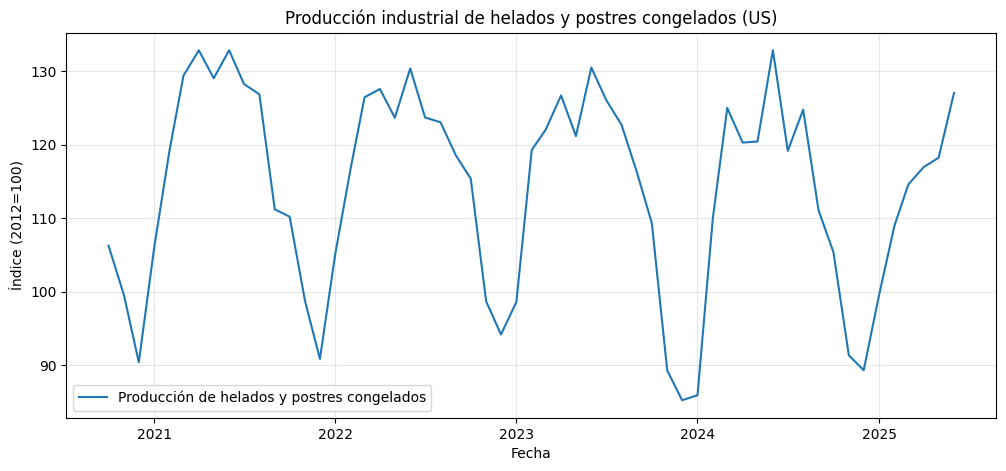

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["value"], label="Producción de helados y postres congelados")
plt.title("Producción industrial de helados y postres congelados (US)")
plt.xlabel("Fecha")
plt.ylabel("Índice (2012=100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Luego de observar que claramente existe un factor de temporada, podemos

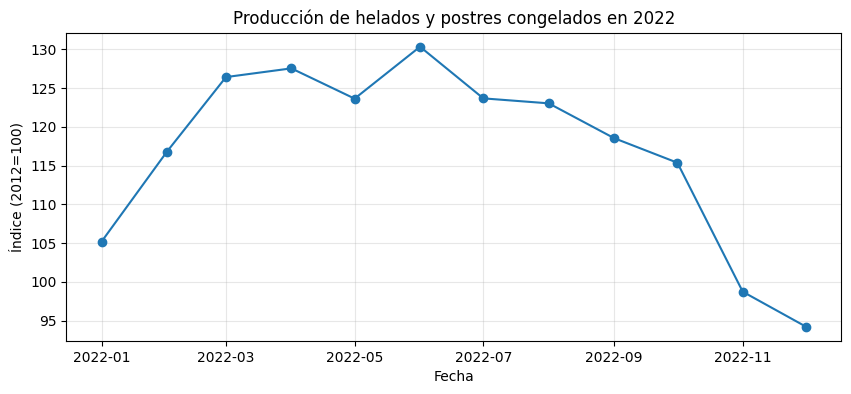

,value
DATE,
2022-01-01,105.1797
2022-02-01,116.7921
2022-03-01,126.4252
2022-04-01,127.5502
2022-05-01,123.6430
2022-06-01,130.3437
2022-07-01,123.6779
2022-08-01,123.0368
2022-09-01,118.5440


In [ ]:
# Elegir el año
year = 2022
df_year = df.loc[str(year)]   # <-- Esto sí busca por fecha en el índice

plt.figure(figsize=(10,4))
plt.plot(df_year.index, df_year["value"], marker="o")
plt.title(f"Producción de helados y postres congelados en {year}")
plt.xlabel("Fecha")
plt.ylabel("Índice (2012=100)")
plt.grid(True, alpha=0.3)
plt.show()

df_year


# 2. Division de Conjuntos

Rango entrenamiento: 2020-10-01 -> 2023-06-01 (33 puntos)
Rango prueba: 2023-07-01 -> 2025-06-01 (24 puntos)


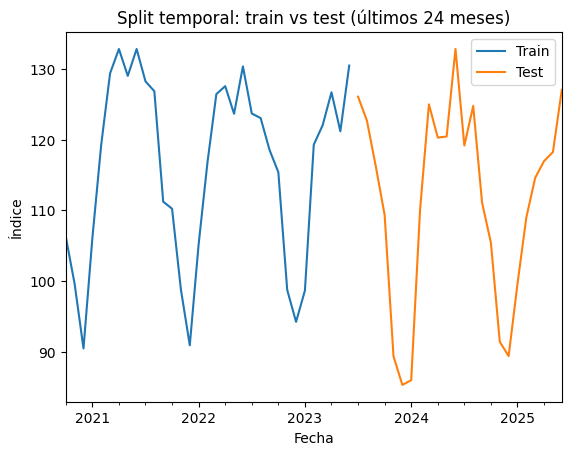

In [ ]:
train = df.iloc[:-24].copy()
test = df.iloc[-24:].copy()

print("Rango entrenamiento:", train.index.min().date(), "->", train.index.max().date(), f"({len(train)} puntos)")
print("Rango prueba:", test.index.min().date(), "->", test.index.max().date(), f"({len(test)} puntos)")

# Visualización
plt.figure()
train["value"].plot(label="Train")
test["value"].plot(label="Test")
plt.title("Split temporal: train vs test (últimos 24 meses)")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.show()


# 3. Normalizacion y Preparacion

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[["value"]].values)
test_scaled  = scaler.transform(test[["value"]].values)

print("Ejemplo - primeros 5 valores escalados (train):")
print(train_scaled[:5].ravel())

# Parámetros para el generador
WINDOW_SIZE = 12     # ej. usar 12 meses para predecir el siguiente
BATCH_SIZE  = 32
HORIZON     = 1      # pasos adelante (1 mes)

train_gen = TimeseriesGenerator(
    data=train_scaled,
    targets=train_scaled,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

val_gen = TimeseriesGenerator(
    data=test_scaled,
    targets=test_scaled,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Batches en train_gen: {len(train_gen)} | WINDOW_SIZE={WINDOW_SIZE} | BATCH_SIZE={BATCH_SIZE}")
print(f"Batches en val_gen:   {len(val_gen)}")

# Función auxiliar para invertir el escalado luego
def inverse_scale(y_scaled):
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    return scaler.inverse_transform(y_scaled).ravel()

Ejemplo - primeros 5 valores escalados (train):
[0.37342624 0.21522615 0.         0.3676363  0.68028116]
Batches en train_gen: 1 | WINDOW_SIZE=12 | BATCH_SIZE=32
Batches en val_gen:   1


# 4. Construccion del Modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

tf.random.set_seed(42)
np.random.seed(42)

def create_lstm_model(lstm_units, input_shape, dropout_rate=0.2):
    model = Sequential([
        LSTM(lstm_units,
             activation='tanh',
             input_shape=input_shape,
             return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

neuron_configs = [16, 32, 64, 128]
input_shape = (WINDOW_SIZE, 1)
models = {}

for units in neuron_configs:
    model = create_lstm_model(
        lstm_units=units,
        input_shape=input_shape,
        dropout_rate=0.2
    )
    models[f'LSTM_{units}'] = model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

/home/Japo/Documents/workspaces/uvg/dataSience/Lab5/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def make_predictions(model, generator, scaler):
    predictions = []
    actual = []

    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        pred = model.predict(batch_x, verbose=0)
        predictions.extend(pred.ravel())
        actual.extend(batch_y.ravel())

    predictions = inverse_scale(predictions)
    actual = inverse_scale(actual)

    return predictions, actual

def plot_comparison(models, val_gen, test_data, model_names=None):
    plt.figure(figsize=(15, 10))

    actual_values = test_data['value'].values[WINDOW_SIZE:]
    actual_dates = test_data.index[WINDOW_SIZE:]

    plt.plot(actual_dates, actual_values, 'ko-', label='Valores Reales', linewidth=2, markersize=6)

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    model_metrics = {}

    for i, (model_name, model) in enumerate(models.items()):
        predictions, _ = make_predictions(model, val_gen, scaler)

        mse = mean_squared_error(actual_values, predictions)
        mae = mean_absolute_error(actual_values, predictions)
        model_metrics[model_name] = {'MSE': mse, 'MAE': mae}

        color = colors[i % len(colors)]
        label = f'{model_name} (MSE: {mse:.2f}, MAE: {mae:.2f})'
        plt.plot(actual_dates, predictions, 'o--', color=color, label=label, alpha=0.7, markersize=4)

    plt.title('Comparación de Predicciones LSTM vs Valores Reales\nÍndice de Producción de Helados y Postres Congelados', fontsize=14)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Índice (2012=100)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model_metrics

## Función para crear modelos complejos

In [ ]:
def create_complex_lstm_models(input_shape):
    complex_models = {}

    # Modelo 1: LSTM Bidireccional
    model1 = Sequential([
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    complex_models['Bidirectional_LSTM'] = model1

    # Modelo 2: LSTM con múltiples capas
    model2 = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])
    model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    complex_models['Multi_Layer_LSTM'] = model2

    # Modelo 3: LSTM con capas densas más profundas
    model3 = Sequential([
        LSTM(128, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model3.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    complex_models['Deep_Dense_LSTM'] = model3

    # Modelo 4: Ensemble-like con diferentes activaciones
    model4 = Sequential([
        LSTM(96, activation='tanh', input_shape=input_shape),
        Dropout(0.25),
        Dense(48, activation='swish'),
        Dropout(0.15),
        Dense(24, activation='relu'),
        Dense(1, activation='linear')
    ])
    model4.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    complex_models['Advanced_LSTM'] = model4

    return complex_models

## Creación de modelos complejos

In [ ]:
complex_models = create_complex_lstm_models(input_shape)

for name, model in complex_models.items():
    print(f"{name}: {model.count_params():,} parámetros")

/home/Japo/Documents/workspaces/uvg/dataSience/Lab5/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Bidirectional_LSTM: 76,065 parámetros
Multi_Layer_LSTM: 32,593 parámetros
Deep_Dense_LSTM: 77,441 parámetros
Advanced_LSTM: 43,489 parámetros


# Entrenar todos los modelos y comparar resultados
trained_models = {}
training_histories = {}

print("=== Entrenando modelos LSTM ===\n")

for model_name, model in models.items():
    print(f"Entrenando {model_name}...")

    # Entrenar el modelo
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0  # Cambiar a 1 si quieres ver el progreso detallado
    )

    trained_models[model_name] = model
    training_histories[model_name] = history

    print(f"{model_name} entrenado - Mejor val_loss: {min(history.history['val_loss']):.4f}")
    print("-" * 50)

print("\n=== Generando predicciones y visualizaciones ===\n")

# Generar el plot de comparación
model_metrics = plot_comparison(trained_models, val_gen, test)

print("\n=== Resumen de métricas por modelo ===")
print("Modelo\t\tMSE\t\tMAE")
print("-" * 40)
for model_name, metrics in model_metrics.items():
    print(f"{model_name}\t{metrics['MSE']:.4f}\t\t{metrics['MAE']:.4f}")

# Encontrar el mejor modelo
best_model_name = min(model_metrics.keys(), key=lambda x: model_metrics[x]['MSE'])
print(f"\nMejor modelo basado en MSE: {best_model_name}")
print(f"MSE: {model_metrics[best_model_name]['MSE']:.4f}, MAE: {model_metrics[best_model_name]['MAE']:.4f}")

# =============================================================================
# GRÁFICAS DE PÉRDIDA INDIVIDUALES PARA CADA MODELO
# =============================================================================

def plot_individual_training_curves(training_histories):
    """
    Plotear curvas de entrenamiento individuales para cada modelo
    """
    n_models = len(training_histories)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (model_name, history) in enumerate(training_histories.items()):
        ax = axes[i]

        # Plot pérdida
        epochs = range(1, len(history.history['loss']) + 1)
        ax.plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2)
        ax.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

        # Encontrar el mejor punto
        best_epoch = np.argmin(history.history['val_loss']) + 1
        best_val_loss = min(history.history['val_loss'])

        ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Mejor época: {best_epoch}')
        ax.scatter([best_epoch], [best_val_loss], color='red', s=100, zorder=5)

        ax.set_title(f'{model_name}\nMejor Val Loss: {best_val_loss:.4f} (Época {best_epoch})', fontsize=12)
        ax.set_xlabel('Época')
        ax.set_ylabel('MSE Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n=== Curvas de entrenamiento individuales ===")
plot_individual_training_curves(training_histories)

In [ ]:
print("\n=== Creando modelos complejos ===")
for name, model in complex_models.items():
    print(f"{name}: {model.count_params():,} parámetros")

print("\n=== Entrenando modelos complejos ===")
trained_complex_models = {}
complex_histories = {}

for model_name, model in complex_models.items():
    print(f"Entrenando {model_name}...")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=150,
        callbacks=[early_stopping],
        verbose=0
    )

    trained_complex_models[model_name] = model
    complex_histories[model_name] = history

    print(f"{model_name} entrenado - Mejor val_loss: {min(history.history['val_loss']):.4f}")
    print("-" * 60)

print("\n=== Comparación de modelos complejos ===")
complex_metrics = plot_comparison(trained_complex_models, val_gen, test)

print("\n=== Gráficas individuales para modelos complejos ===")
plot_individual_training_curves(complex_histories)

## Entrenar modelos complejos

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.


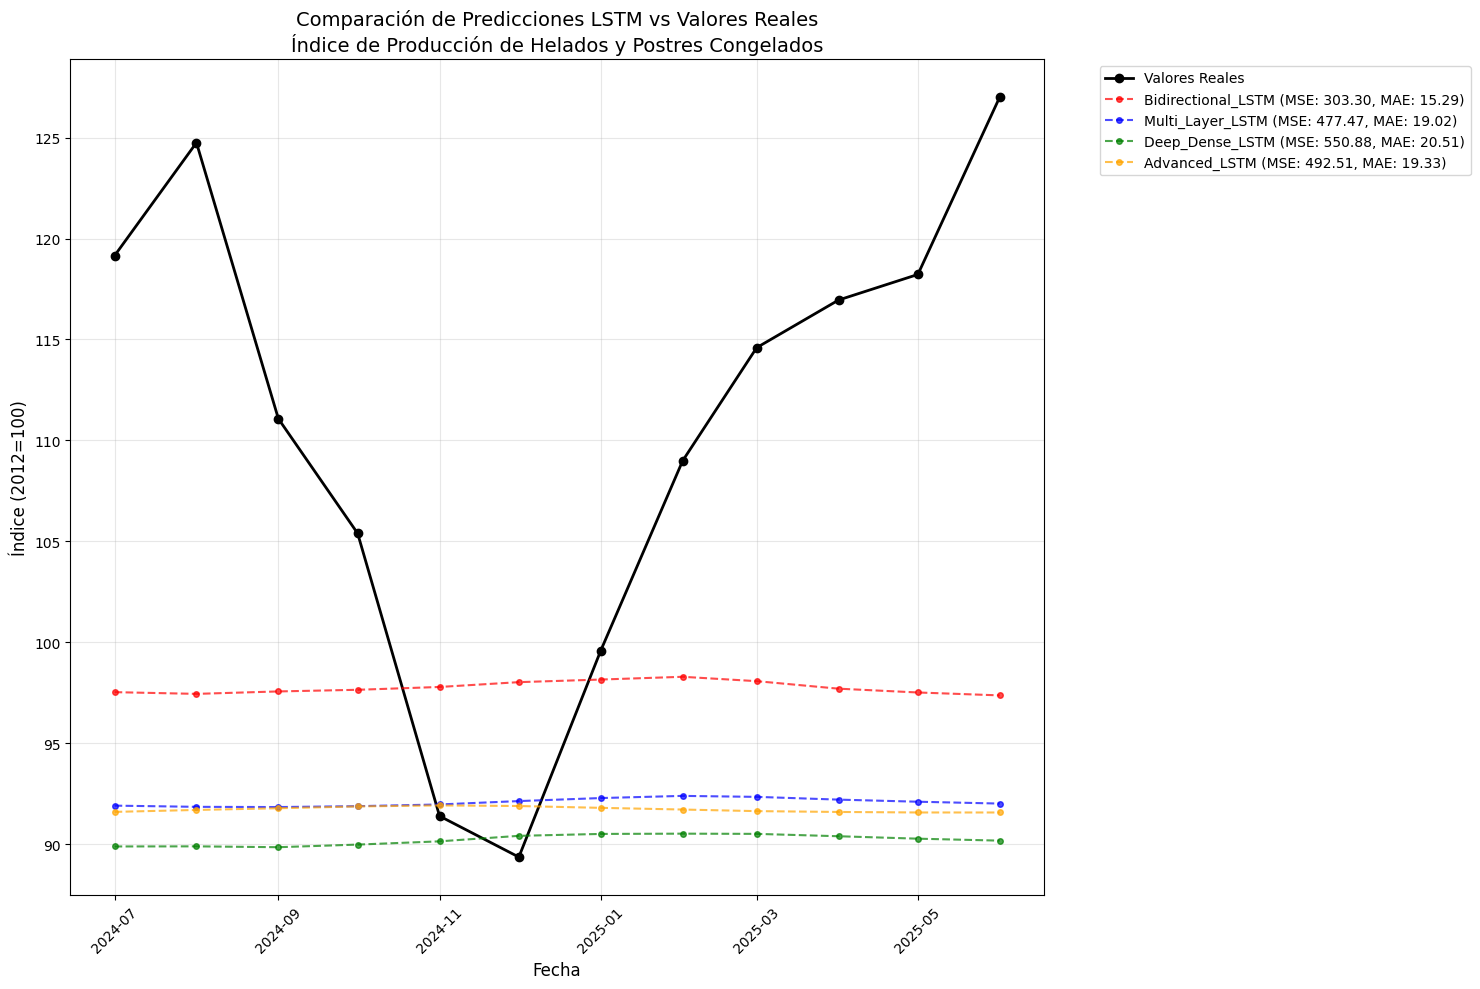

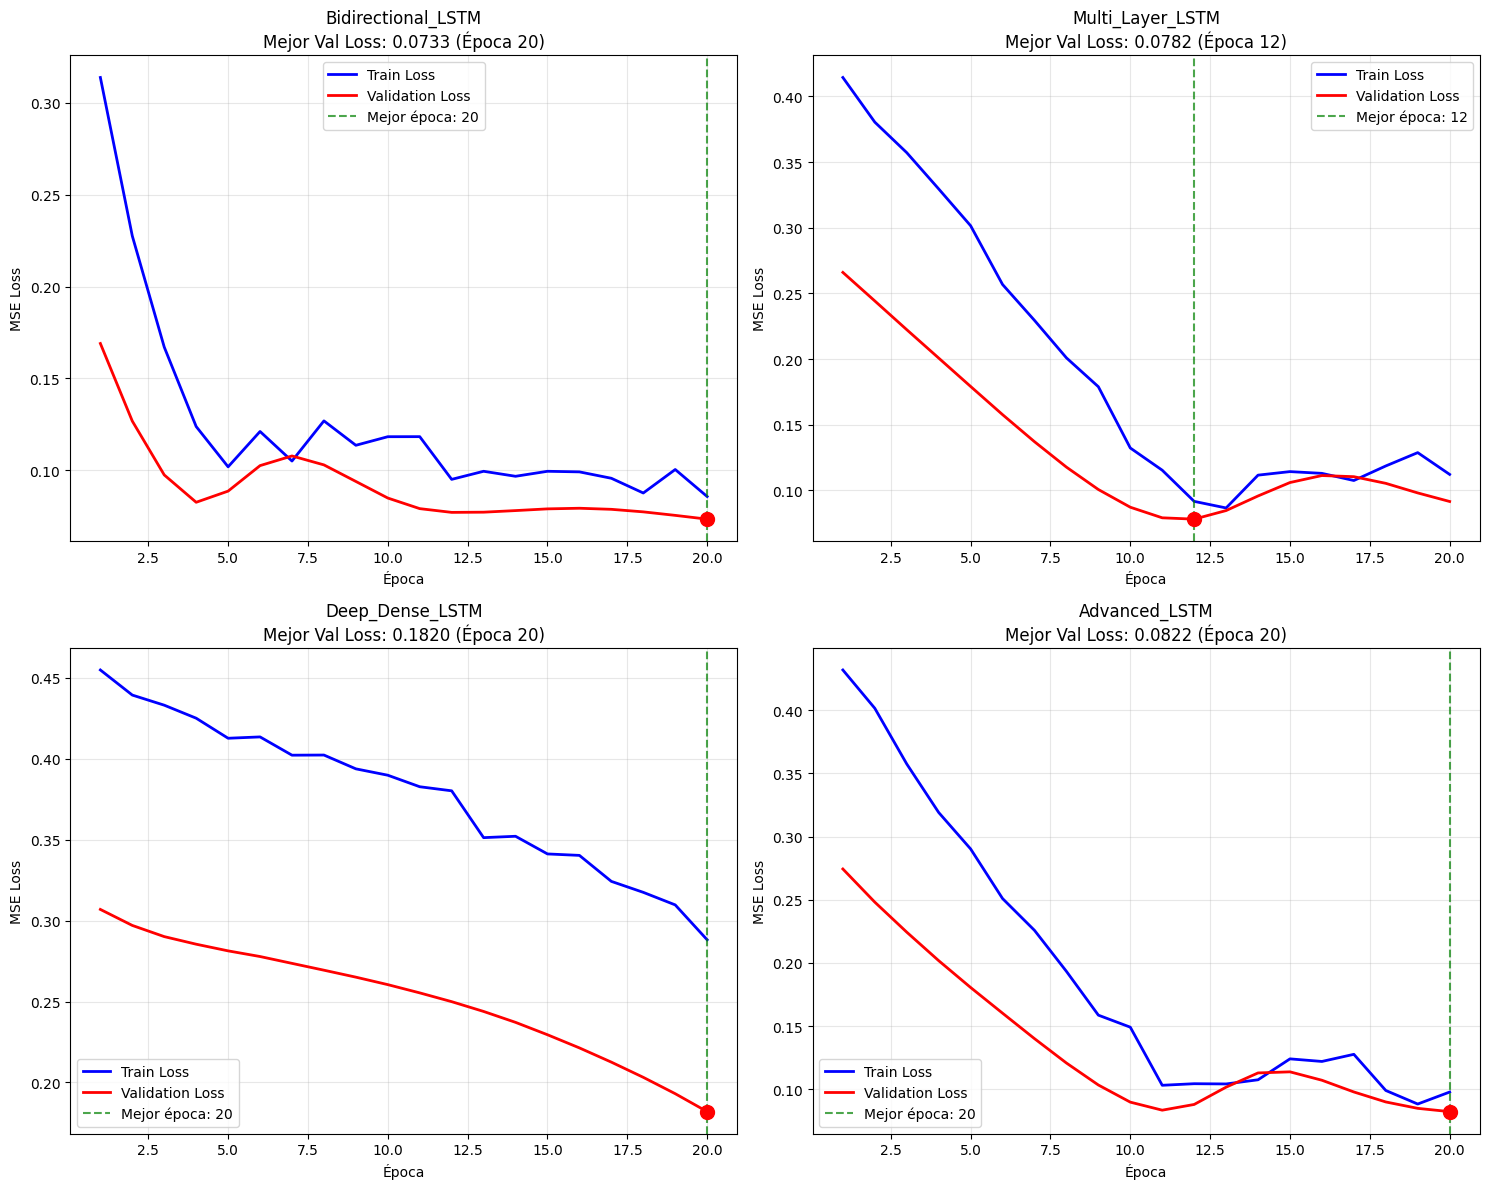

In [ ]:
trained_complex_models = {}
complex_histories = {}

for model_name, model in complex_models.items():
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=150,
        callbacks=[early_stopping],
        verbose=0
    )

    trained_complex_models[model_name] = model
    complex_histories[model_name] = history

complex_metrics = plot_comparison(trained_complex_models, val_gen, test)
plot_individual_training_curves(complex_histories)

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 21.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.


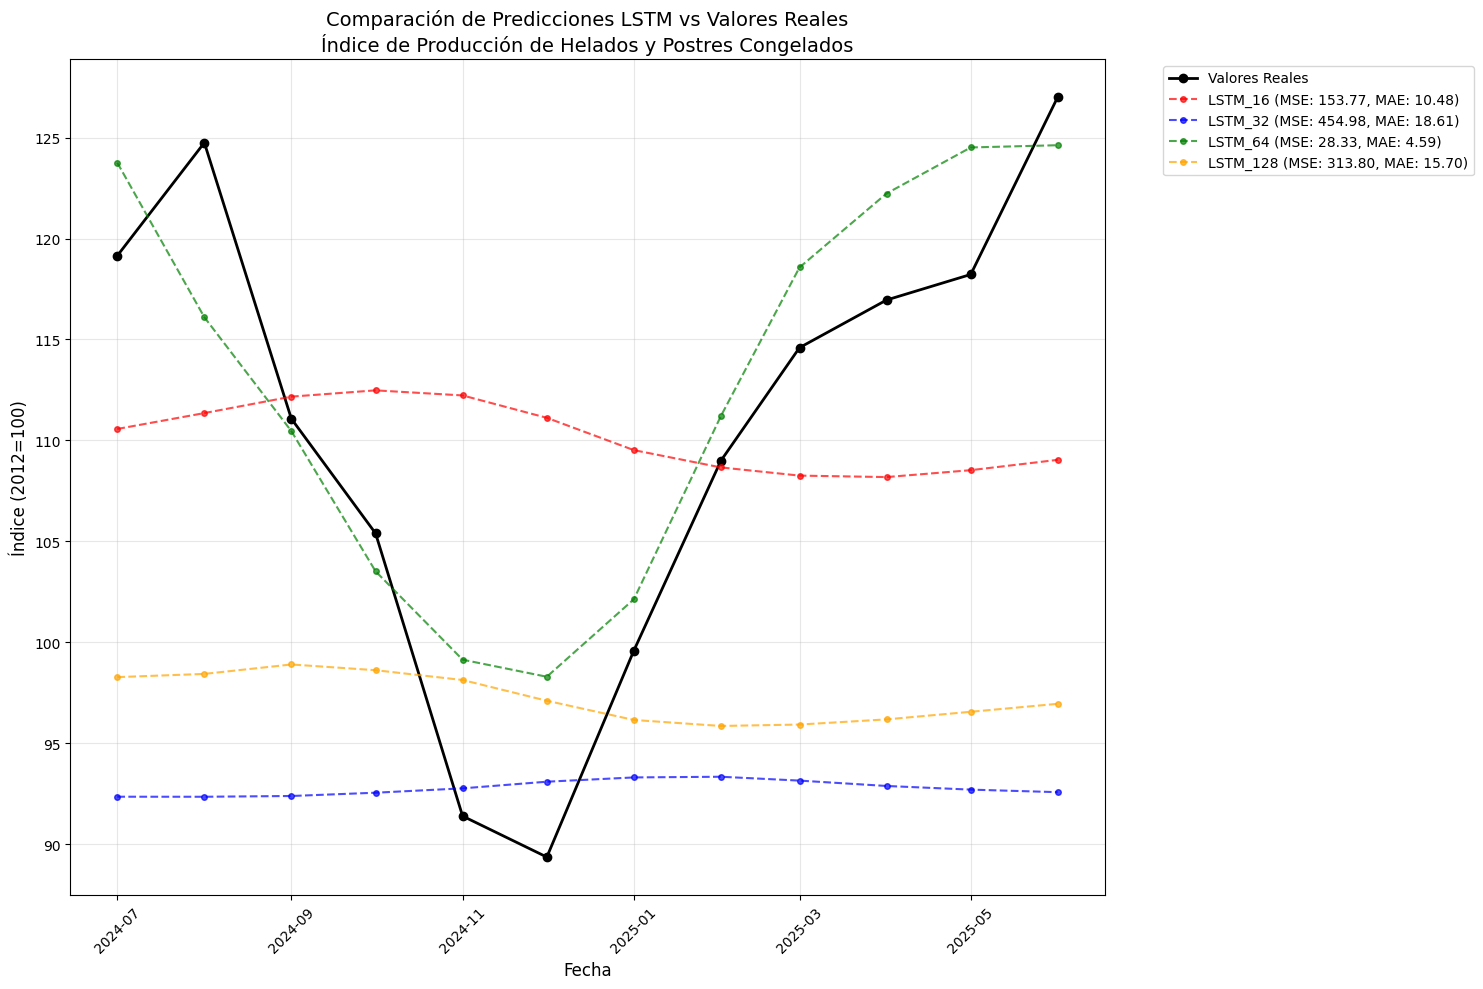

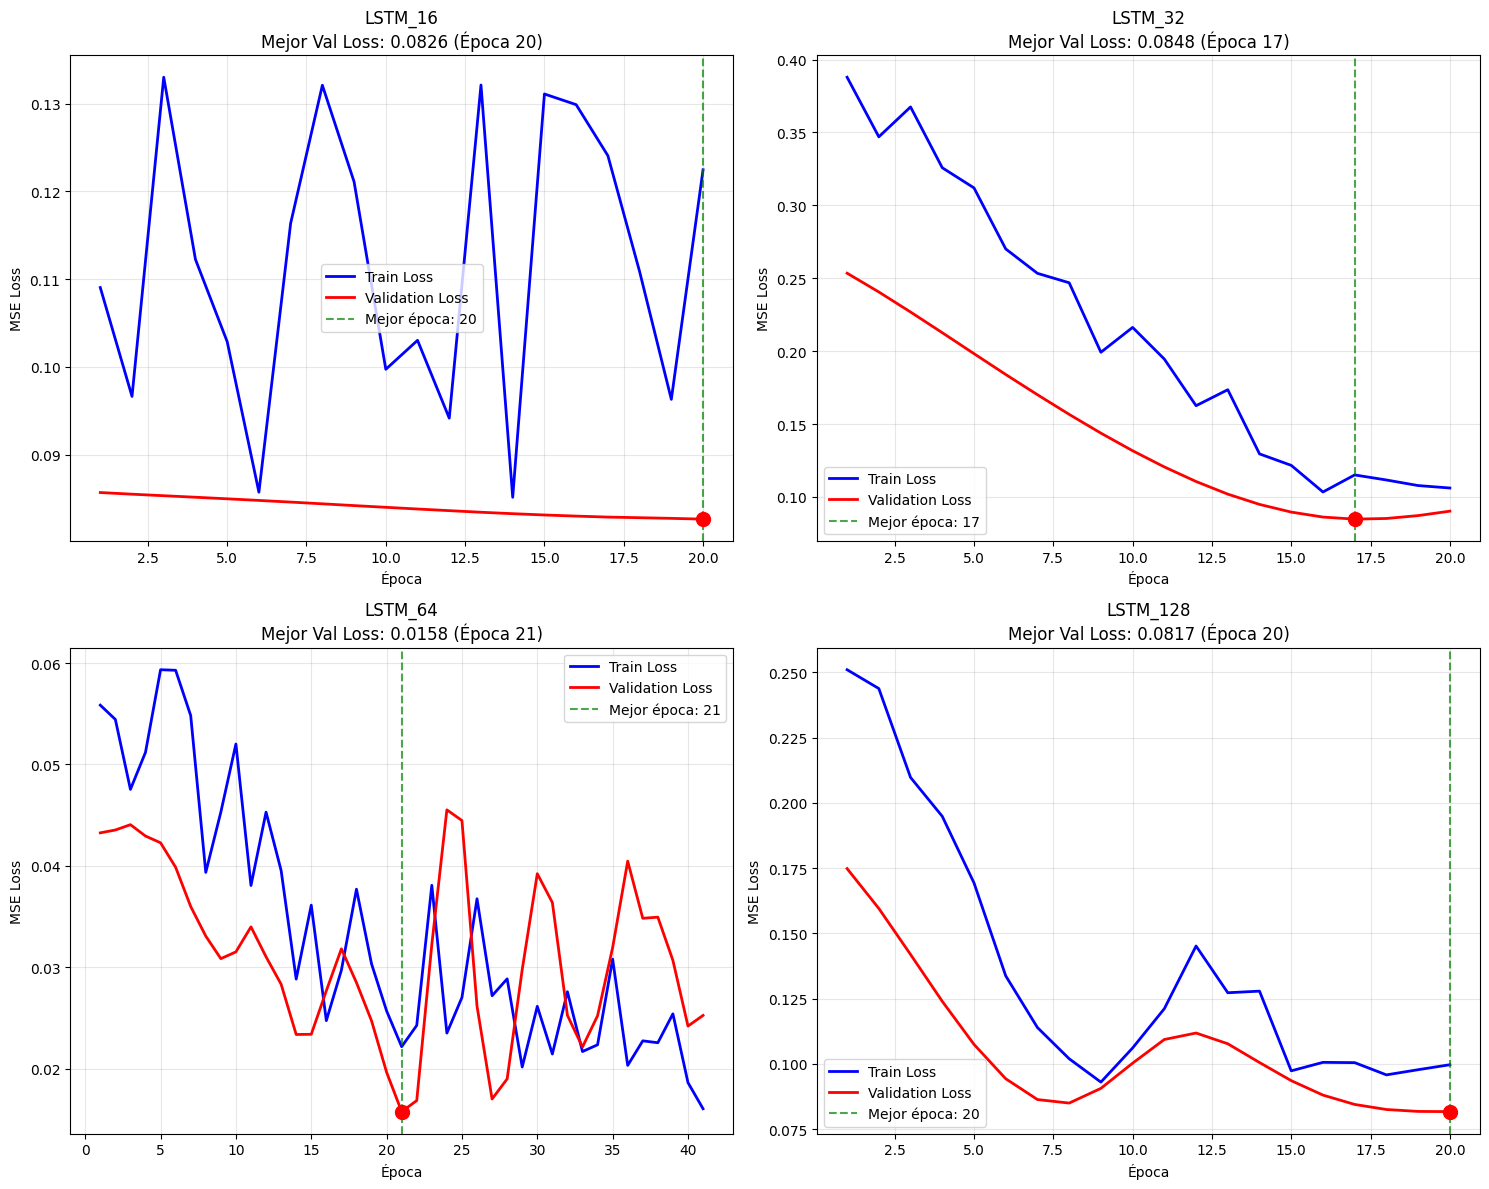

In [ ]:
trained_models = {}
training_histories = {}

for model_name, model in models.items():
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )
    
    trained_models[model_name] = model
    training_histories[model_name] = history

model_metrics = plot_comparison(trained_models, val_gen, test)

best_model_name = min(model_metrics.keys(), key=lambda x: model_metrics[x]['MSE'])

def plot_individual_training_curves(training_histories):
    n_models = len(training_histories)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (model_name, history) in enumerate(training_histories.items()):
        ax = axes[i]

        epochs = range(1, len(history.history['loss']) + 1)
        ax.plot(epochs, history.history['loss'], 'b-', label='Train Loss', linewidth=2)
        ax.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

        best_epoch = np.argmin(history.history['val_loss']) + 1
        best_val_loss = min(history.history['val_loss'])

        ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Mejor época: {best_epoch}')
        ax.scatter([best_epoch], [best_val_loss], color='red', s=100, zorder=5)

        ax.set_title(f'{model_name}\nMejor Val Loss: {best_val_loss:.4f} (Época {best_epoch})', fontsize=12)
        ax.set_xlabel('Época')
        ax.set_ylabel('MSE Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_individual_training_curves(training_histories)

In [ ]:
all_models_metrics = {**model_metrics, **complex_metrics}

sorted_models = sorted(all_models_metrics.items(), key=lambda x: x[1]['MSE'])

overall_best = min(all_models_metrics.keys(), key=lambda x: all_models_metrics[x]['MSE'])
overall_worst = max(all_models_metrics.keys(), key=lambda x: all_models_metrics[x]['MSE'])

for model_name, metrics in sorted_models:
    print(f"{model_name}: MSE={metrics['MSE']:.4f}, MAE={metrics['MAE']:.4f}")

print(f"\nMejor modelo: {overall_best}")
print(f"Peor modelo: {overall_worst}")

LSTM_64: MSE=28.3341, MAE=4.5931
LSTM_16: MSE=153.7668, MAE=10.4831
Bidirectional_LSTM: MSE=303.2953, MAE=15.2927
LSTM_128: MSE=313.8034, MAE=15.6981
LSTM_32: MSE=454.9828, MAE=18.6055
Multi_Layer_LSTM: MSE=477.4749, MAE=19.0233
Advanced_LSTM: MSE=492.5094, MAE=19.3315
Deep_Dense_LSTM: MSE=550.8787, MAE=20.5057

Mejor modelo: LSTM_64
Peor modelo: Deep_Dense_LSTM
